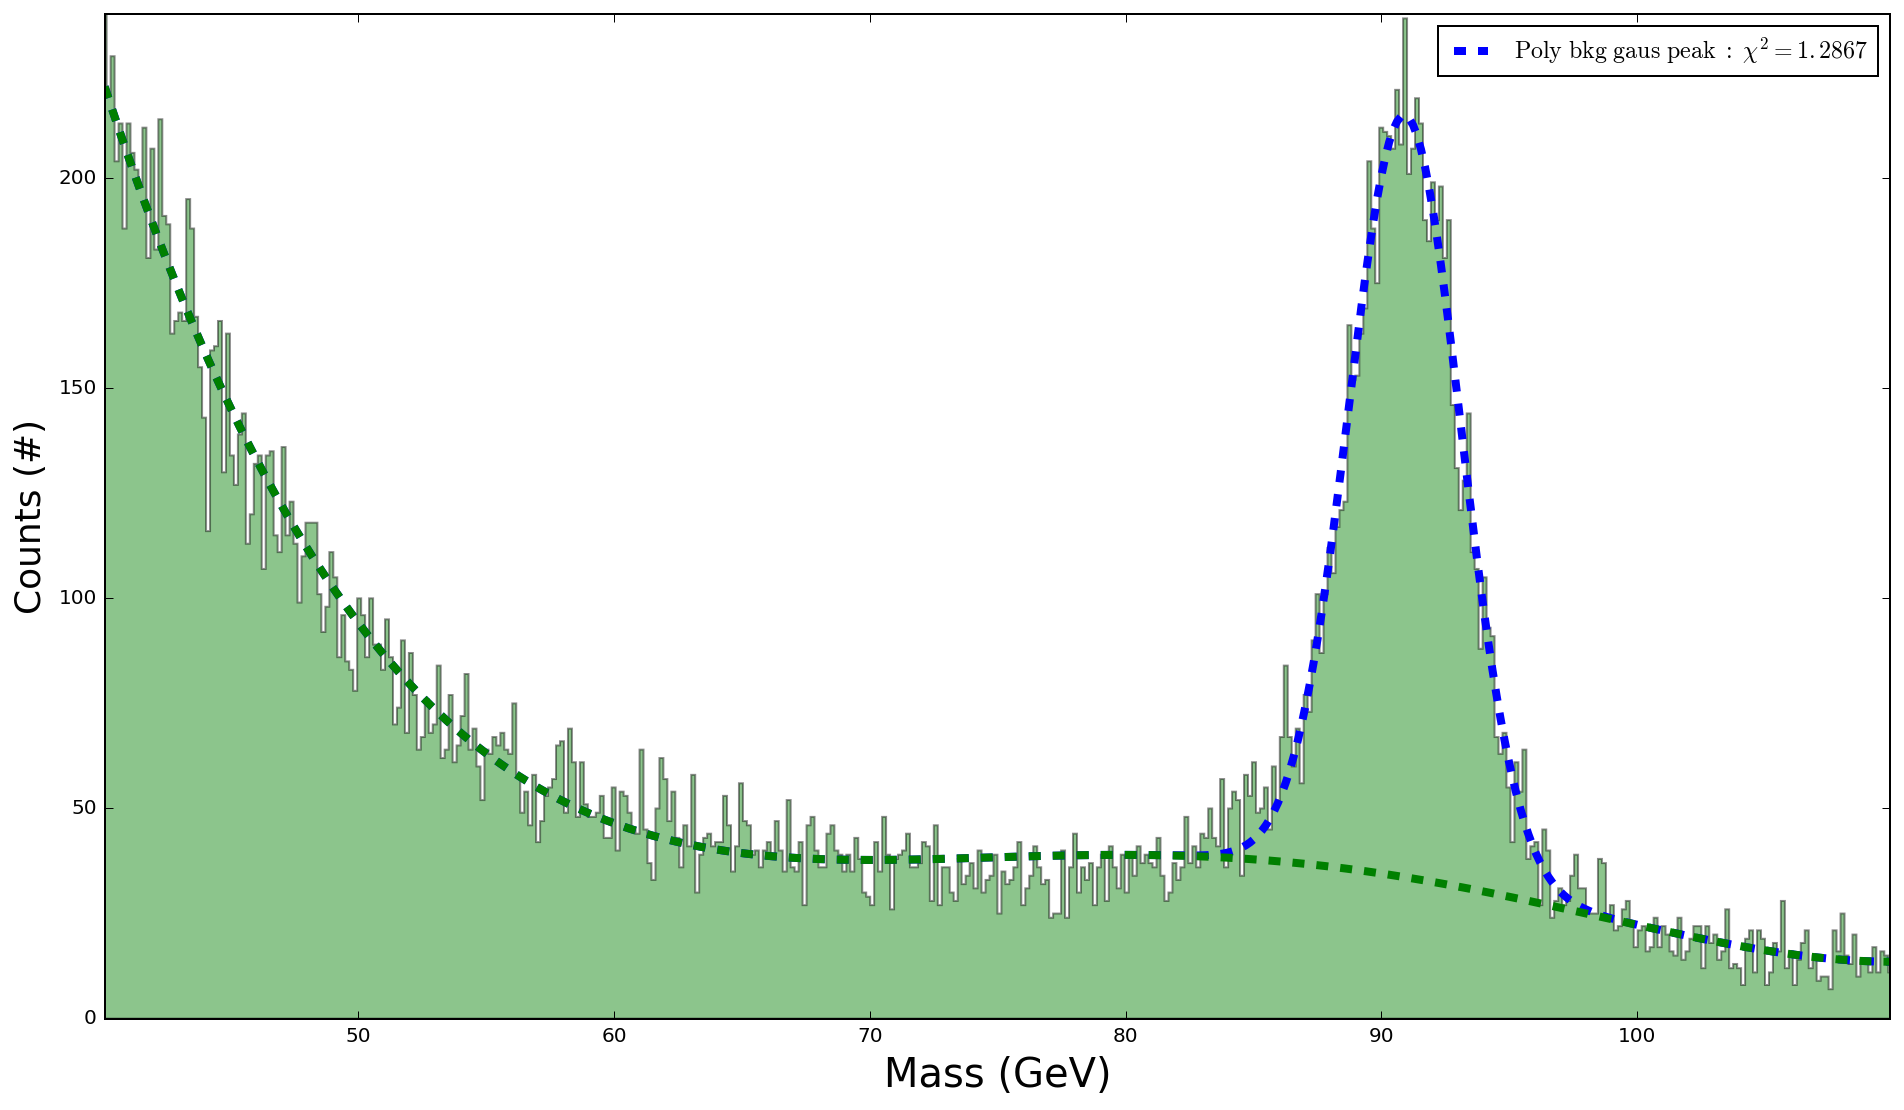

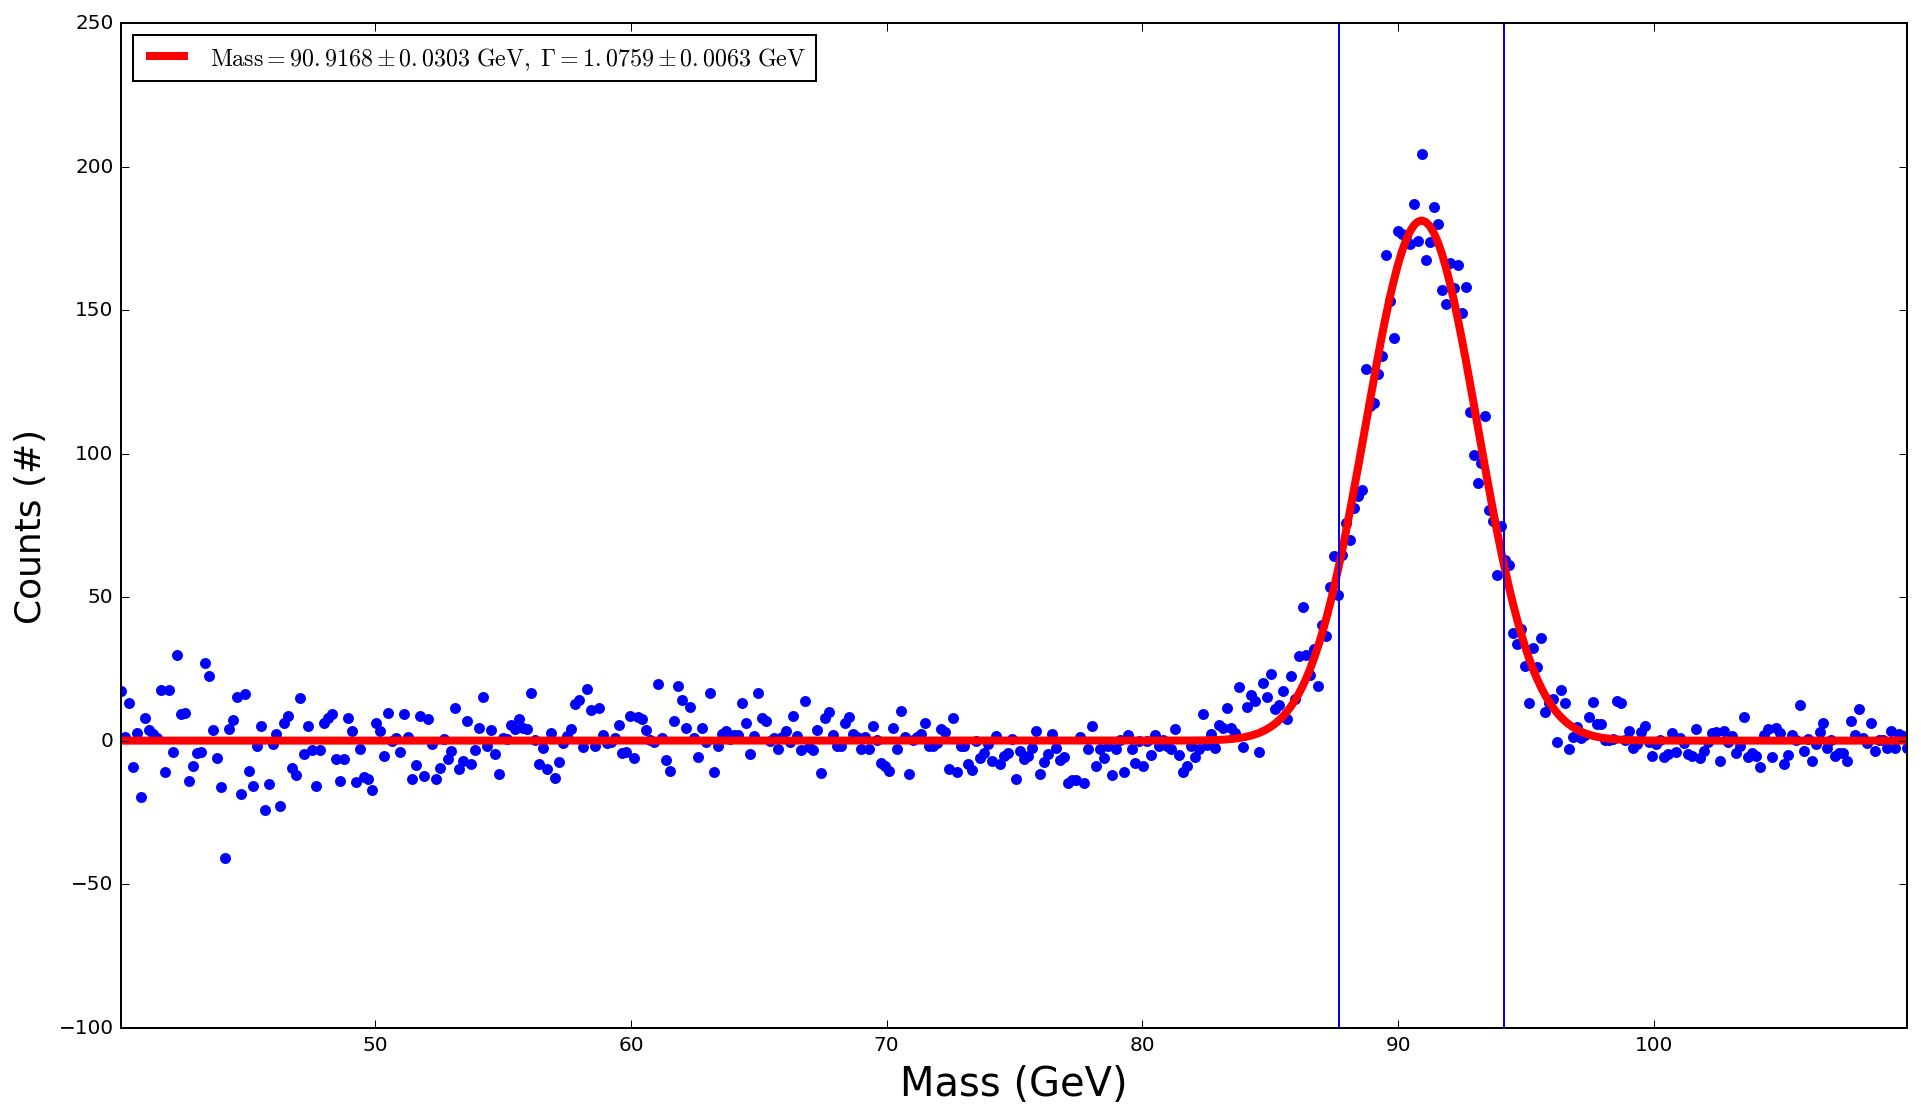

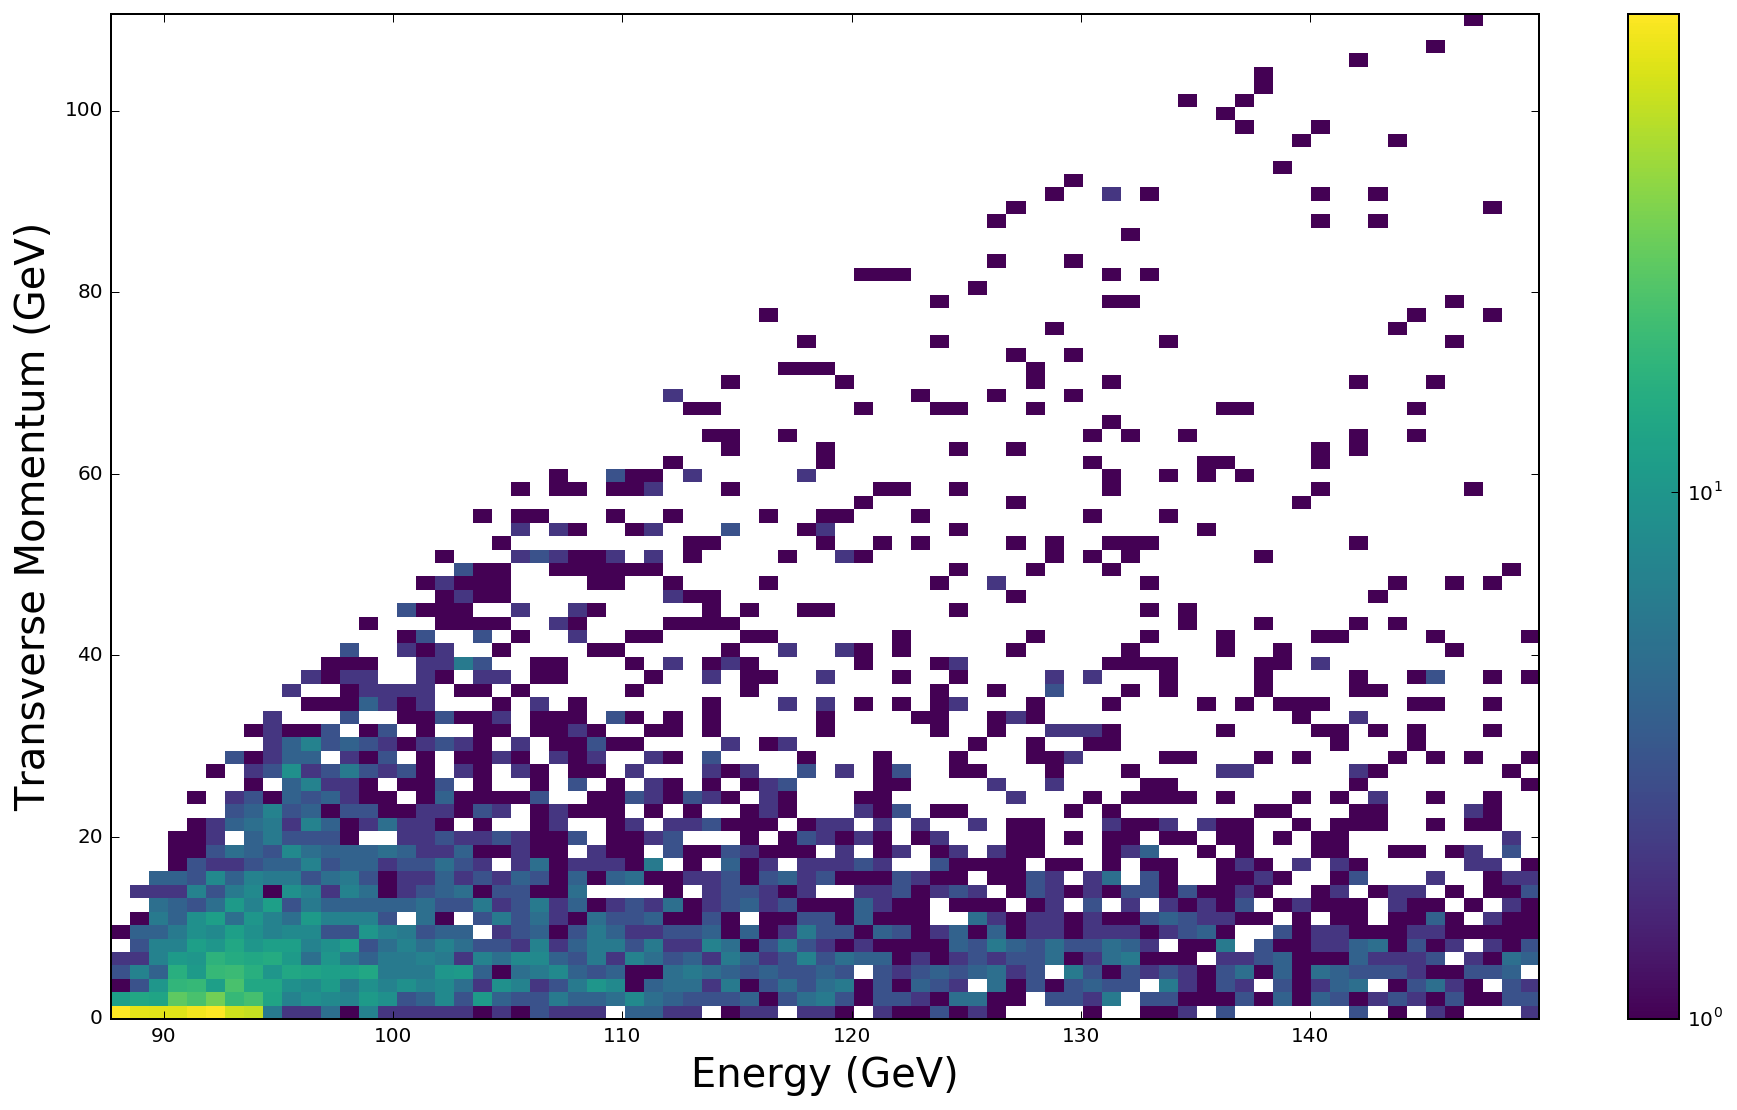

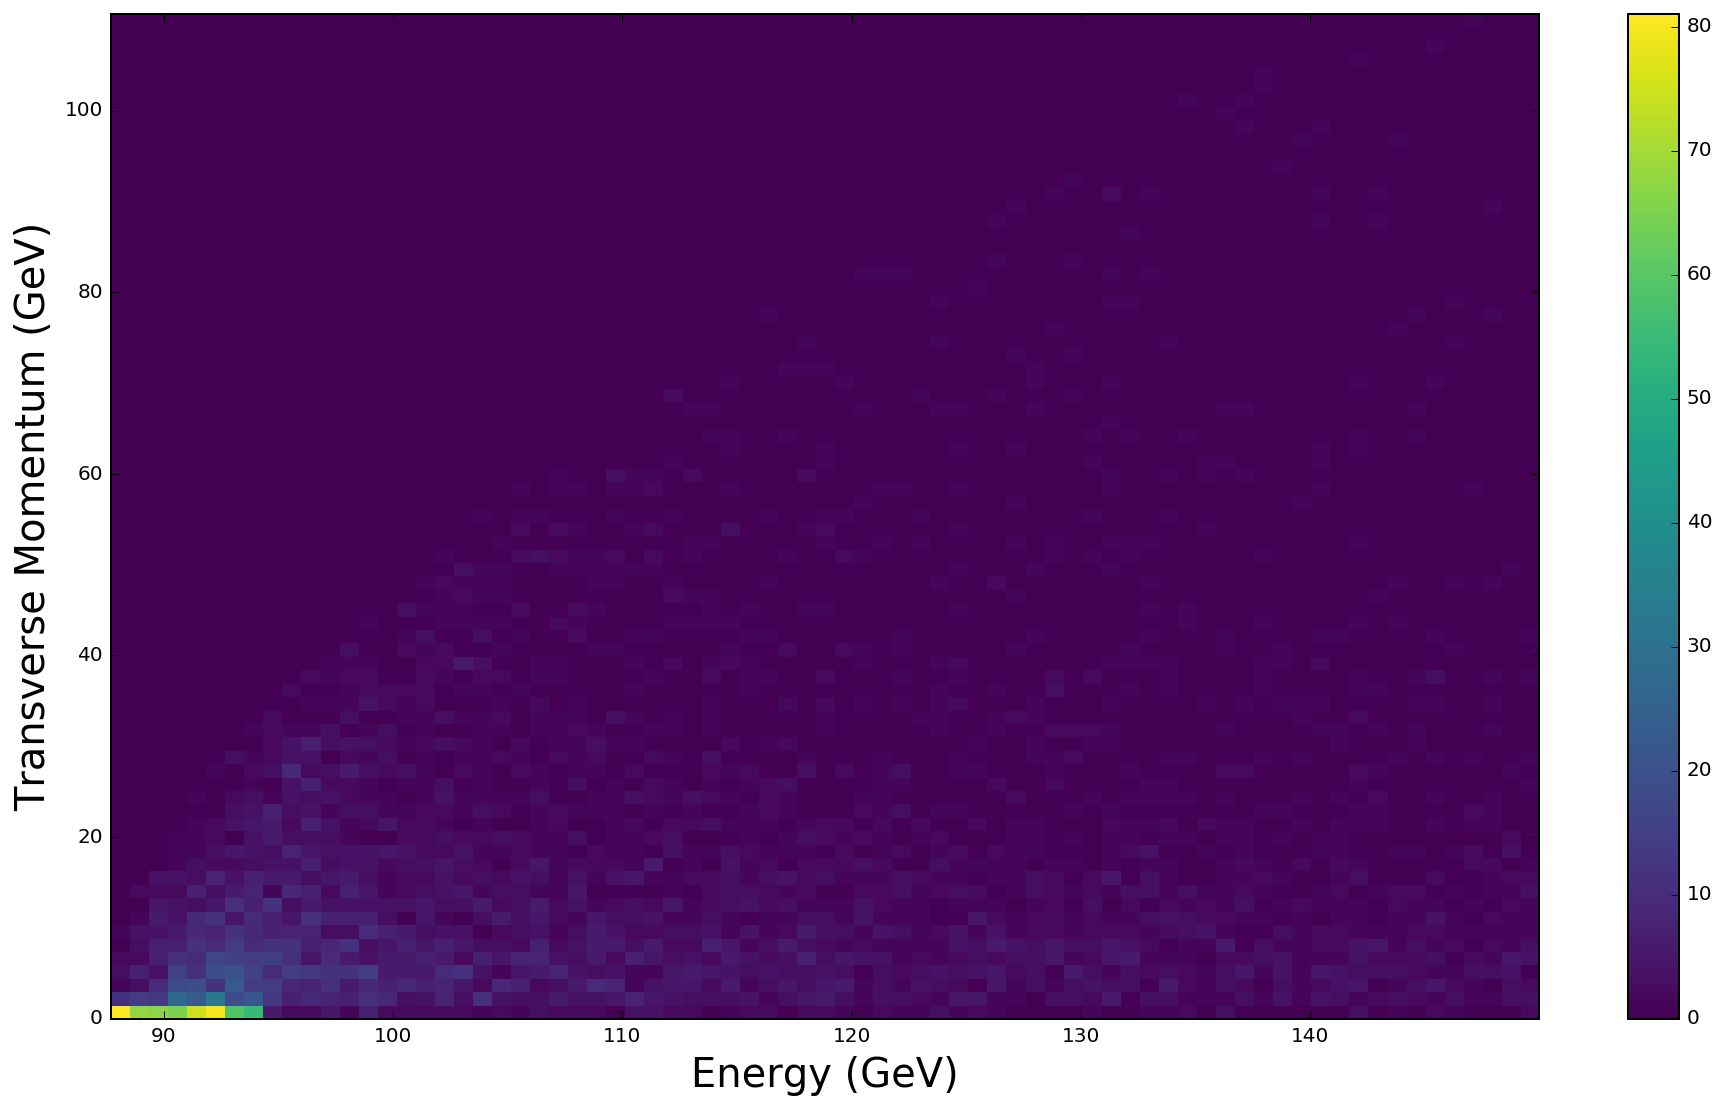

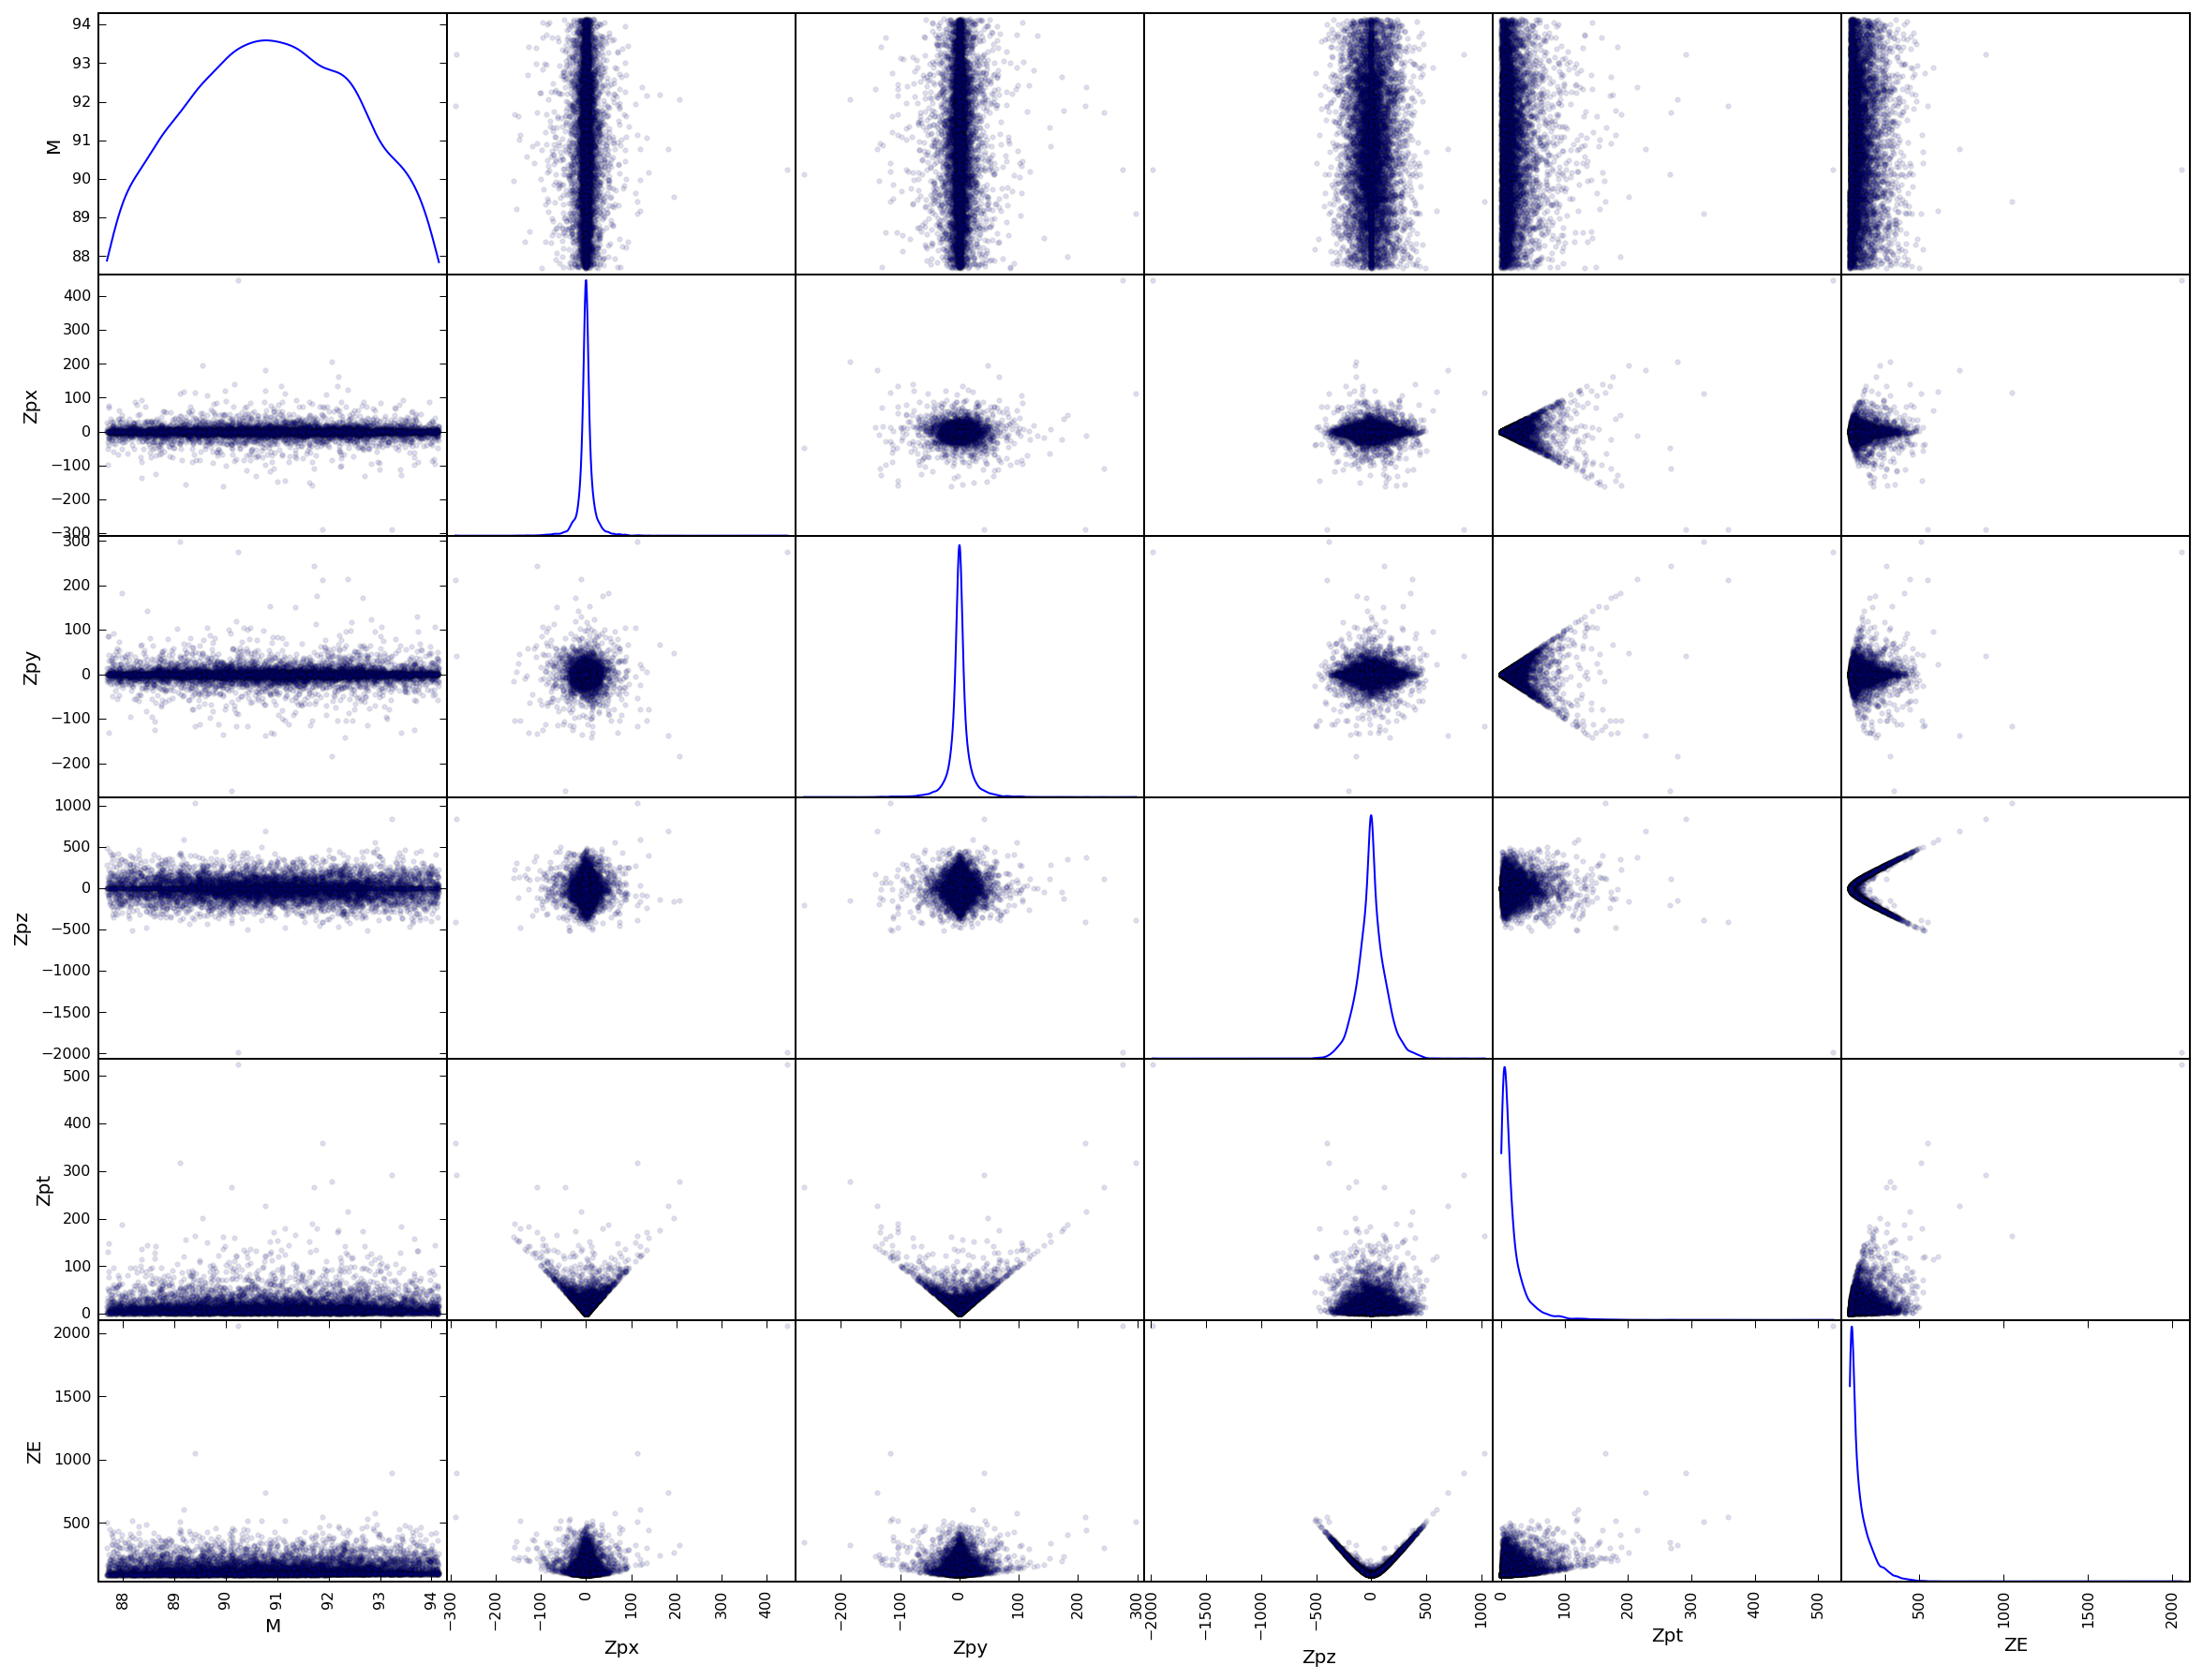

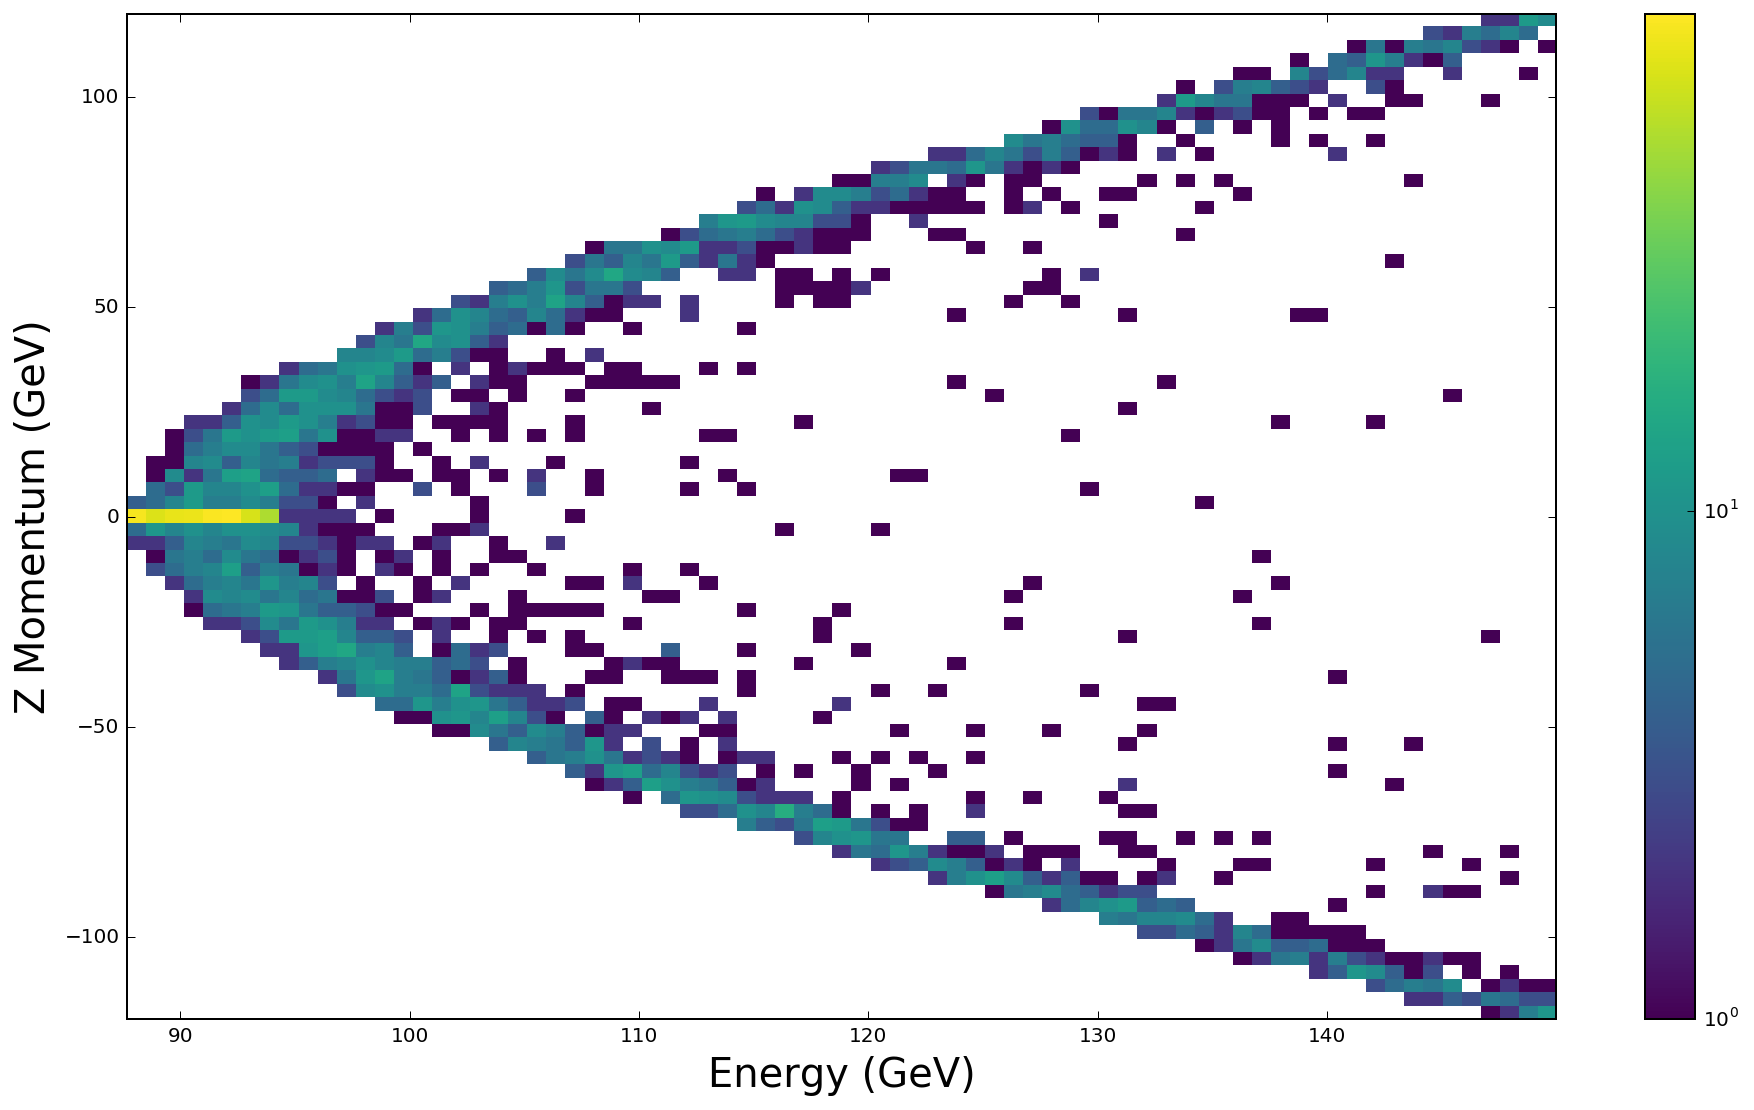

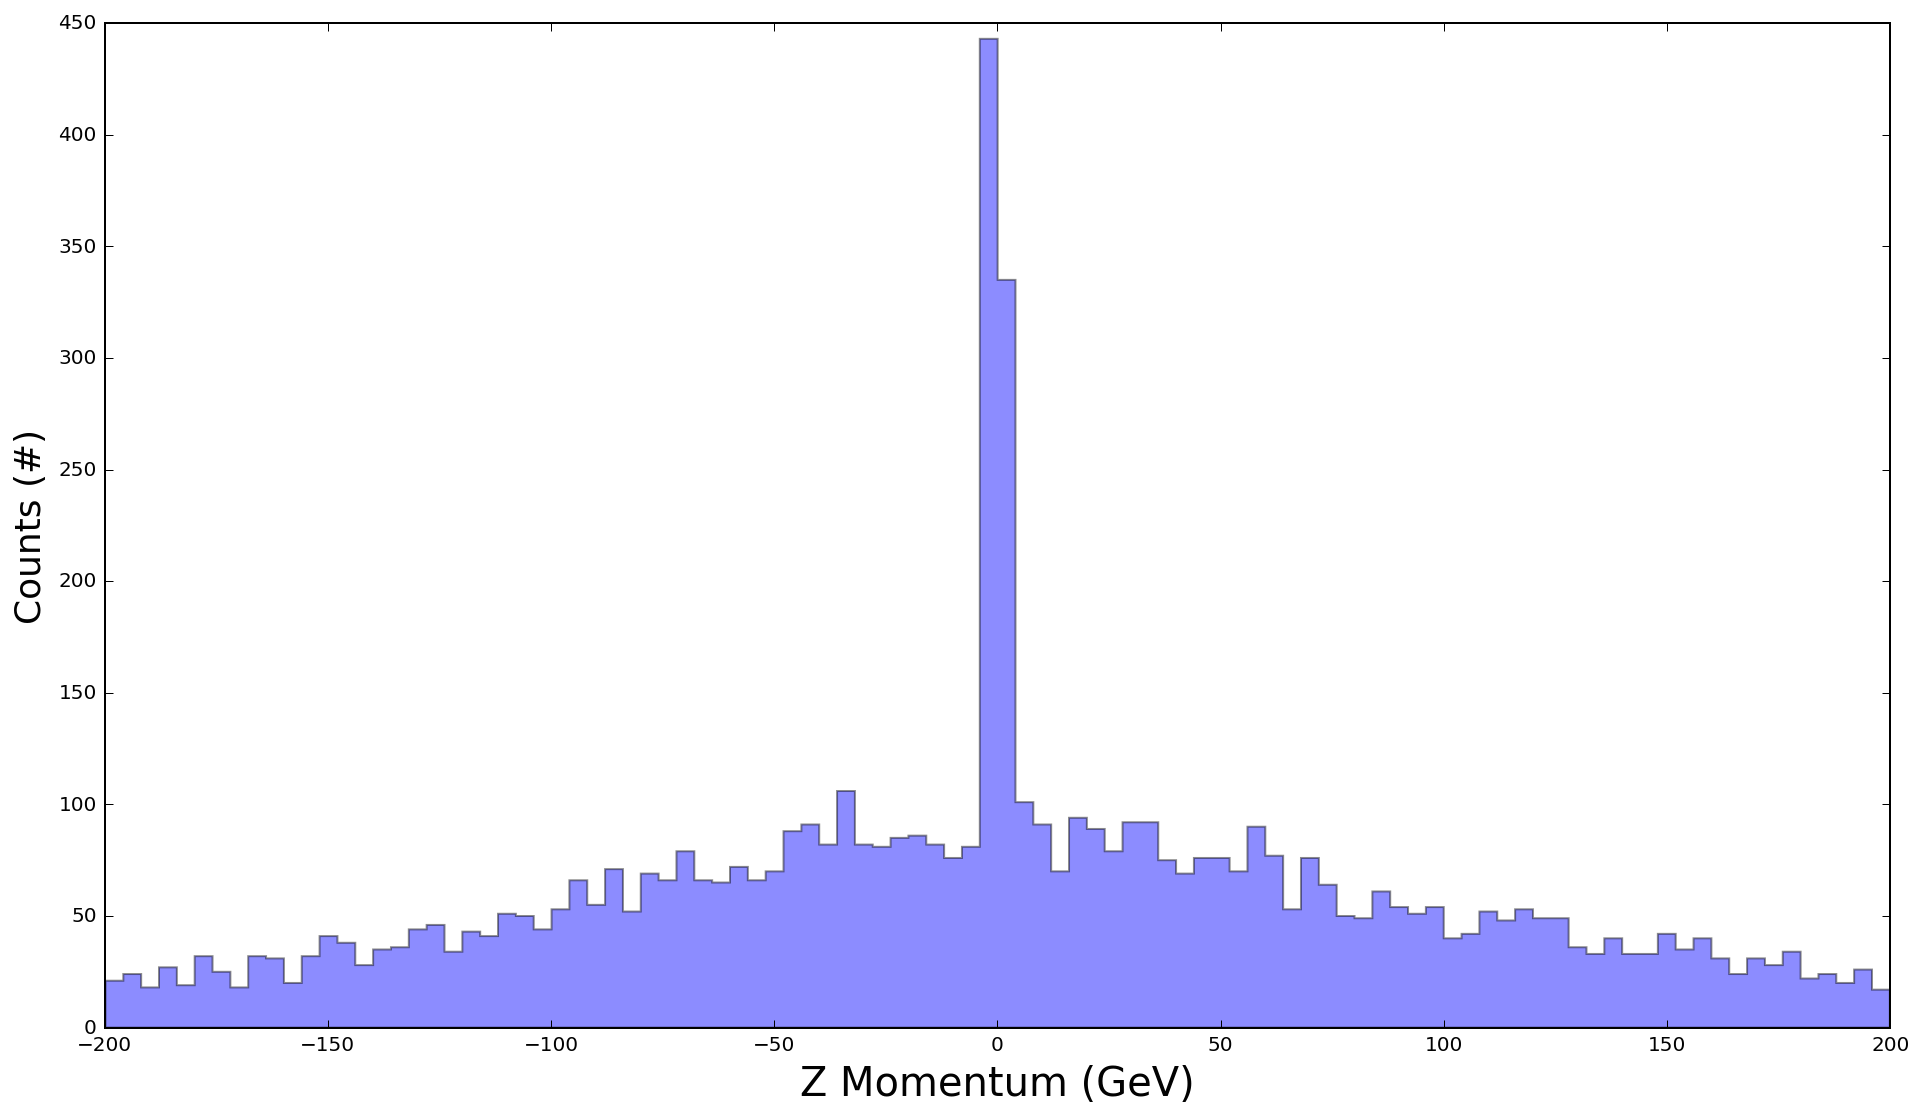

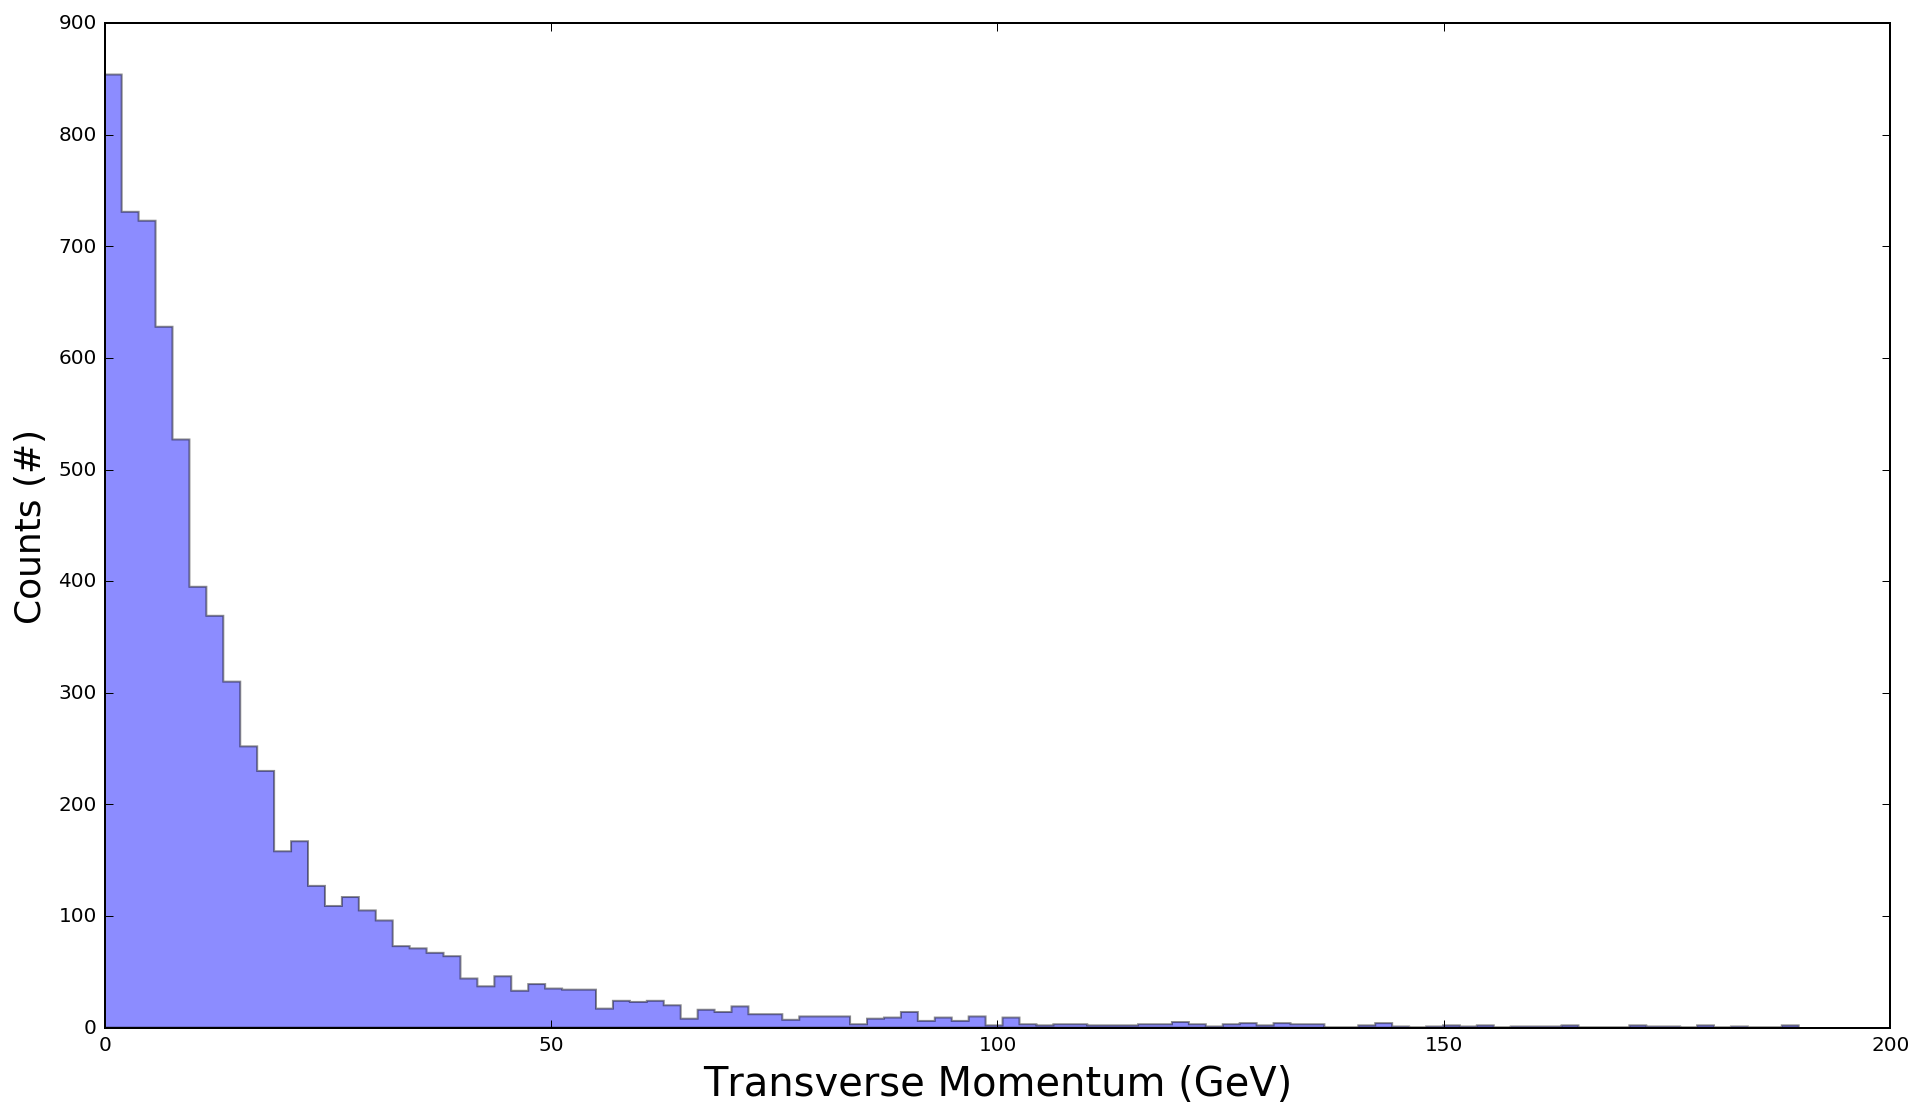

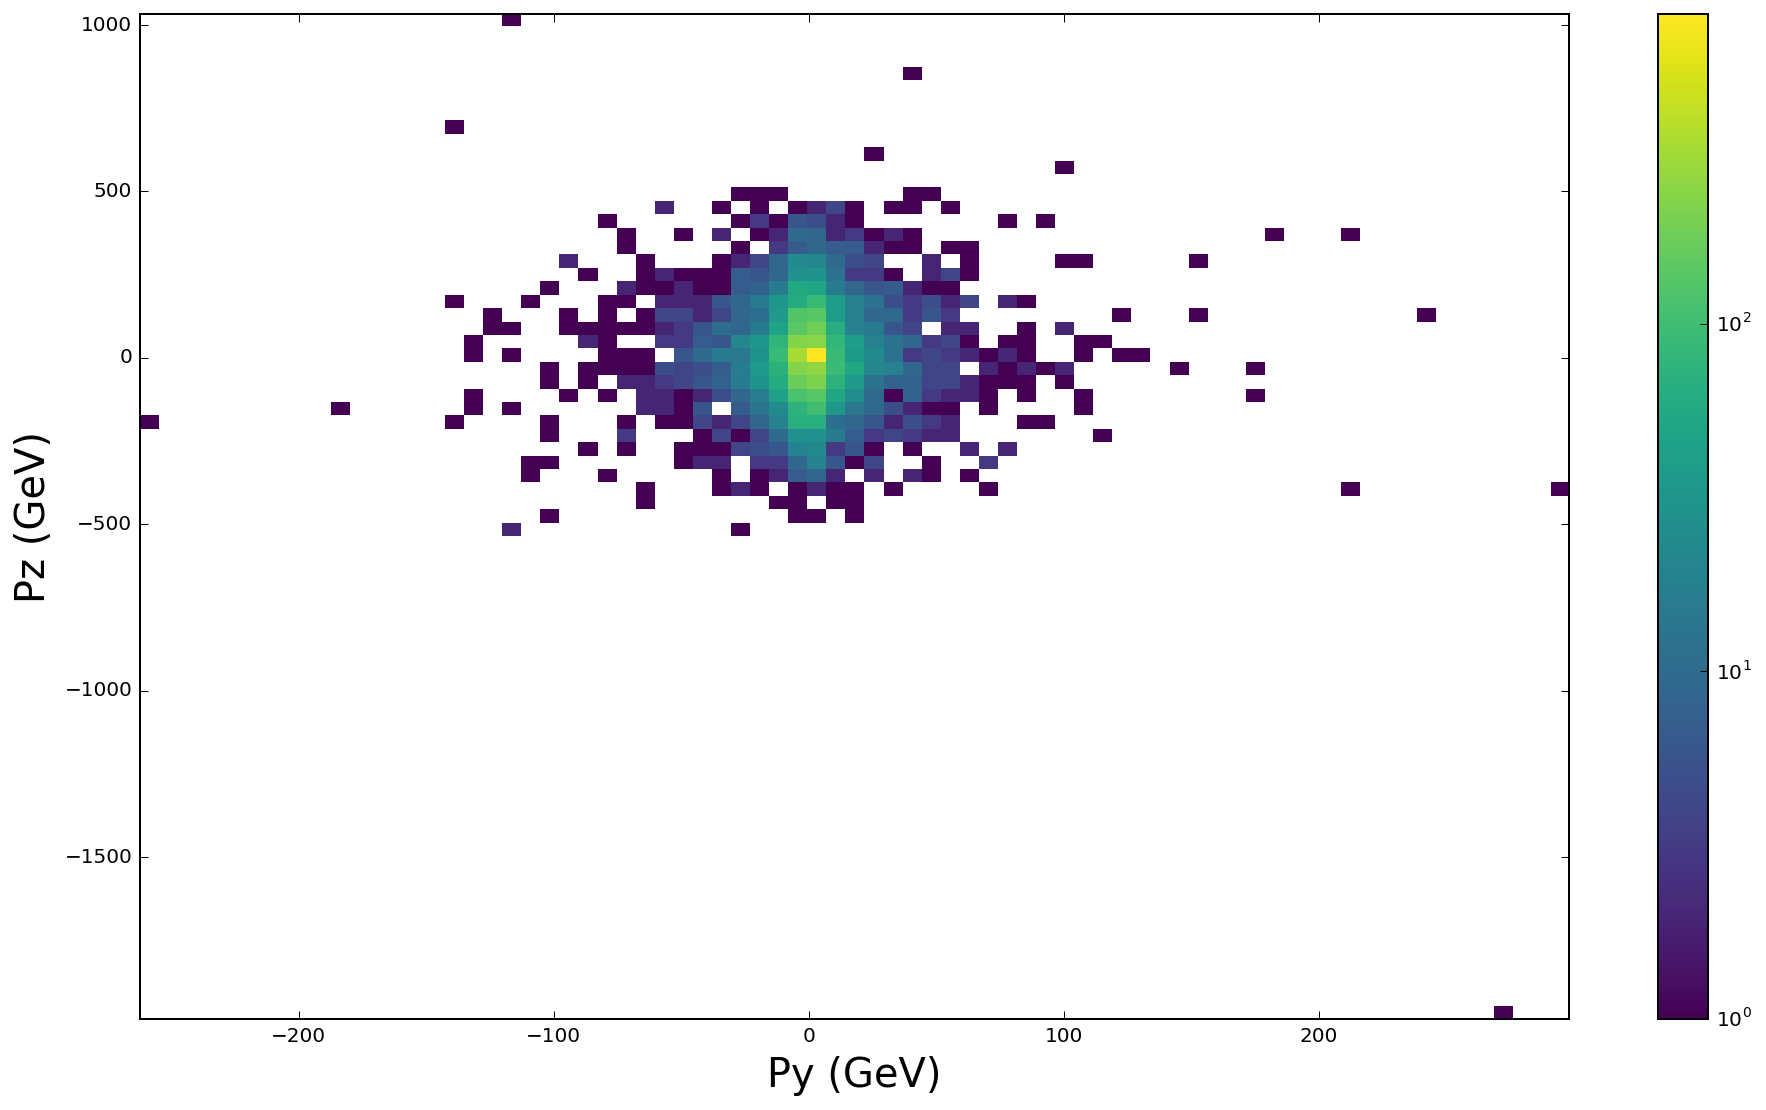

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from pandas.tools.plotting import scatter_matrix
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

df = pd.read_csv('/Users/tylern/Homework/PHYS723/project/LHC/CMS_data/MuRun.csv')

#Make sure events are neutral
#if first event is positive and the second is negative
#or the second is positive and the first is negative
df1 = df[df.Q1 == 1]
df1 = df1[df1.Q2 == -1]

df2 = df[df.Q1 == -1]
df2 = df2[df2.Q2 == 1]

frames = [df1, df2]

df = pd.concat(frames)

mass_z = 91.1876

def poly(x, c1, c2, c3, c4):
    return c1*x*x*x + c2*x*x + c3*x + c4

def big_poly(x, c1, c2, c3, c4, c5, c6, c7, c8):
    #return c8*x**7 + c7*x**6 + c6*x**5 + c5*x**4 + c4*x**3 + c3*x**2 + c2*x + c1
    return c5*x**4 + c4*x**3 + c3*x**2 + c2*x + c1

def gaussian(x, mu, sig, const):
    return const * 1/(sig*np.sqrt(2*np.pi)) * np.exp(-(x - mu)**2 / 2*sig**2)

def gaus_poly(x, mu, sig, cont, c1, c2, c3, c4):
    return poly(x, c1, c2, c3, c4) + gaussian(x, mu, sig, cont)

def big_poly_gaus(x, mu, sig, cont, c1, c2, c3, c4, c5, c6, c7, c8):
    return gaussian(x, mu, sig, cont) + big_poly(x, c1, c2, c3, c4, c5, c6, c7, c8)

def chi_2(ys,yknown):
    total = 0
    for i in xrange(len(yknown)):
        temp = (ys[i]-yknown[i])**2.0
        if yknown[i] == 0:
            total += 1
        else :
            total += temp/yknown[i]
    return total/len(yknown)

fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
mass = df[df.M > 40].M

num_bins = 450

hist, bin_edges = np.histogram(mass,bins=num_bins)
xdata = 0.5*(bin_edges[1:]+bin_edges[:-1])
ydata = hist

popt_1, pcov_1 = curve_fit(big_poly, xdata, ydata)

plt.hist(mass, num_bins, histtype=u'stepfilled',facecolor='g' , alpha=0.45)

x0 = np.array([mass_z,0.04,1,popt_1[0],popt_1[1],popt_1[2],popt_1[3],popt_1[4],popt_1[5],popt_1[6],popt_1[7]])
popt_1, pcov_1 = curve_fit(big_poly_gaus, xdata, ydata,p0=x0,maxfev = 200000)

c2 = chi_2(big_poly_gaus(xdata, *popt_1),ydata)
plt.plot(xdata,big_poly_gaus(xdata,*popt_1),'b--', lw=4,
    label=r'$\mathrm{Poly\ bkg\ gaus\ peak\ : \ \chi^{2} = %.4f}$' %(c2))
plt.plot(xdata,big_poly(xdata,*popt_1[3:]),'g--', lw=4)

plt.ylim((0,np.max(ydata)))
plt.xlim((np.min(xdata),np.max(xdata)))
plt.xlabel(r'Mass (GeV)', fontsize=20)
plt.ylabel(r'Counts (#)', fontsize=18)
plt.legend(loc=0)
#plt.savefig('Mass_histogram.pdf')
plt.show()

fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
popt_1, pcov_1 = curve_fit(big_poly_gaus, xdata, ydata,p0=x0,maxfev = 200000)

signal = []
for i in xrange(num_bins):
    temp = ydata[i] - big_poly(xdata[i],*popt_1[3:])
    signal.append(temp)

plt.scatter(xdata, signal,marker='o', color='b')

popt_1, pcov_1 = curve_fit(gaussian, xdata, signal,p0=[mass_z,1,1],maxfev = 200000)
perr_1 = np.sqrt(np.diag(pcov_1))
plt.plot(xdata,gaussian(xdata,*popt_1),'r', lw=4,
    label=r'$\mathrm{Mass=%.4f \pm %.4f \ GeV,\ \Gamma=%.4f \pm %.4f \ GeV}$' 
    %(popt_1[0], perr_1[0], popt_1[1]*(2.0*np.sqrt(2.0 * np.log(2))), perr_1[1]))

mean,width = popt_1[0],popt_1[1]
sigma = width* (2.0*np.sqrt(2.0 * np.log(2)))

plt.axvline(x=(mean - 3.0*sigma))
plt.axvline(x=(mean + 3.0*sigma))

plt.xlim((np.min(xdata),np.max(xdata)))
plt.xlabel(r'Mass (GeV)', fontsize=20)
plt.ylabel(r'Counts (#)', fontsize=18)
plt.legend(loc=0)
#plt.savefig('Z_peak.pdf')
plt.show()

Zs = df[df.M > (mean - 3.0*sigma)]
Zs = Zs[Zs.M < (mean + 3.0*sigma)]

Zs['Zpx'] = Zs.px1+Zs.px2
Zs['Zpy'] = Zs.py1+Zs.py2
Zs['Zpz'] = Zs.pz1+Zs.pz2
Zs['Zpt'] = np.sqrt(np.square(Zs.Zpx) + np.square(Zs.Zpy))
Zs['ZE'] = Zs.E1+Zs.E2

#########################################
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
temp = Zs[Zs.Zpt < 120]
temp = temp[temp.ZE < 150]
plt.hist2d(temp.ZE,temp.Zpt,bins=75,cmap='viridis',norm=LogNorm())
plt.xlabel(r'Energy (GeV)', fontsize=20)
plt.ylabel(r'Transverse Momentum (GeV)', fontsize=20)
plt.colorbar()
#plt.savefig('Ze_Zpt_log.pdf')
plt.show()
#########################################
#########################################
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
temp = Zs[Zs.Zpt < 120]
temp = temp[temp.ZE < 150]
plt.hist2d(temp.ZE,temp.Zpt,bins=75,cmap='viridis')#,norm=LogNorm())
plt.xlabel(r'Energy (GeV)', fontsize=20)
plt.ylabel(r'Transverse Momentum (GeV)', fontsize=20)
plt.colorbar()
#plt.savefig('Ze_Zpt.pdf')
plt.show()
#########################################
#########################################
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
temp = Zs.drop(['Event','Run','Type1','Type2'],axis=1)
temp = temp.drop(['E1','px1','py1','pz1','pt1','eta1','phi1','Q1'],axis=1)
temp = temp.drop(['E2','px2','py2','pz2','pt2','eta2','phi2','Q2'],axis=1)
scatter_matrix(temp, alpha=0.1, figsize=(20, 15),diagonal='kde')
#plt.savefig('scatter_matrix.pdf')
plt.show()
#########################################
#########################################
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
temp = Zs[Zs.Zpz < 120]
temp = temp[temp.ZE < 150]
plt.hist2d(temp.ZE,temp.Zpz,bins=75,cmap='viridis',norm=LogNorm())
plt.xlabel(r'Energy (GeV)', fontsize=20)
plt.ylabel(r'Z Momentum (GeV)', fontsize=20)
plt.colorbar()
#plt.savefig('ZE_Zpz.pdf')
plt.show()
#########################################
#########################################
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
temp = Zs[np.abs(Zs.Zpz) < 200]
plt.hist(temp.Zpz, 100, histtype=u'stepfilled',facecolor='b' , alpha=0.45)
plt.ylabel(r'Counts (#)', fontsize=18)
plt.xlabel(r'Z Momentum (GeV)', fontsize=20)
#plt.colorbar()
#plt.savefig('Zpz.pdf')
plt.show()
#########################################
#########################################
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
temp = Zs[np.abs(Zs.Zpt) < 200]
plt.hist(temp.Zpt, 100, histtype=u'stepfilled',facecolor='b' , alpha=0.45)
plt.ylabel(r'Counts (#)', fontsize=18)
plt.xlabel(r'Transverse Momentum (GeV)', fontsize=20)
#plt.colorbar()
#plt.savefig('Zpt.pdf')
plt.show()
#########################################